In [1]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
# import pymc3 as pm

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

In [2]:
def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path):
    try:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))+'.txt'
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    except IOError:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err, sum(n_combine))

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, 2.845, num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)

## NFW model

In [4]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

## Sersic + NFW model

In [5]:
def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,2e-5,4e-5,13.1, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0],[1000, 1e-3, 1e-3, 100, 10]))
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2



In [6]:
def aic(chi2,n,k):
    return chi2 + 2*k + k*(k+1)/(n-k-1)

## Power Law Model

In [7]:
def power_law(r, I, a):
    
    return I*r**a

from scipy.optimize import curve_fit
def fit_power(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(power_law,xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    res = ydata - power_law(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

In [8]:
# a plot demostrating the profiles



In [9]:
a = np.array([0,0,0])
# a = a[1:]
len(a.shape)
a==0

array([ True,  True,  True])

## Total Satellite Sample

In [53]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

# move value<=0 to 1e-10 to avoid bad behavior from plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

Q-frac for lm central 0.374
Q-frac for lm central 0.388
Q-frac for lm central 0.351
fitting NFW+Sersic
dof: 6
[2.903e+02 2.331e-05 5.049e-05 3.425e+01 2.523e-01] [2.629e+01 2.470e-06 6.383e-06 2.577e+00 9.313e-02] Chi2_dof=0.98
[2.858e+02 2.236e-05 4.241e-05 3.625e+01 4.659e-01] [4.108e+01 3.810e-06 9.147e-06 3.928e+00 2.878e-01] Chi2_dof=1.96
[5.097e+02 1.290e-05 3.661e-04 1.224e+01 3.297e+00] [9.486e+01 2.636e-06 2.093e-03 2.983e+01 8.499e+00] Chi2_dof=1.08


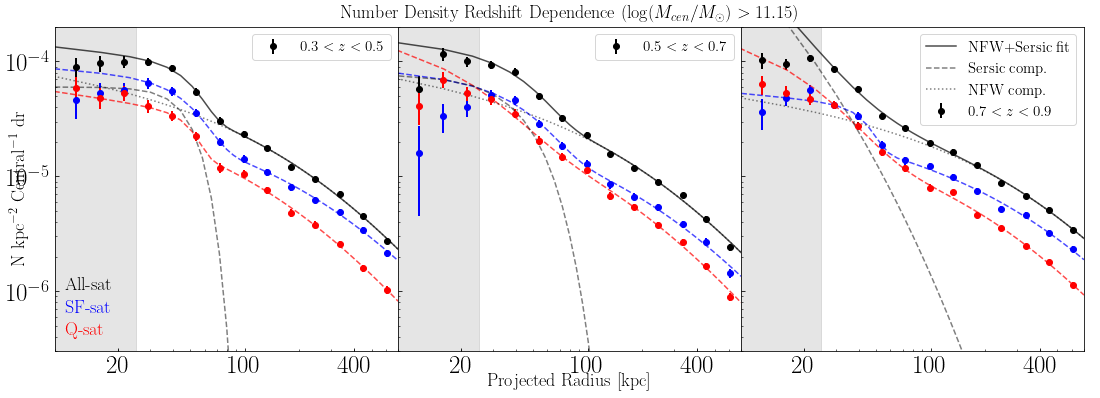

In [38]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

path = 'CUT_deep_catalogs/total_sample/'  # sfprob cut at 0.5
# path = 'CUT_deep_catalogs/total_sample_sfprob_3bins/'  #sfprob cut at low=0.4, high=0.8

csfq = 'all'
count_radial_4 = combine_deep(csfq,'all','9.5','13.0',0.4,path)
count_radial_6 = combine_deep(csfq,'all','9.5','13.0',0.6,path)
count_radial_8 = combine_deep(csfq,'all','9.5','13.0',0.8,path)
count_radial_4_sf = combine_deep(csfq,'ssf','9.5','13.0',0.4,path)
count_radial_6_sf = combine_deep(csfq,'ssf','9.5','13.0',0.6,path)
count_radial_8_sf = combine_deep(csfq,'ssf','9.5','13.0',0.8,path)
count_radial_4_q = combine_deep(csfq,'sq','9.5','13.0',0.4,path)
count_radial_6_q = combine_deep(csfq,'sq','9.5','13.0',0.6,path)
count_radial_8_q = combine_deep(csfq,'sq','9.5','13.0',0.8,path)

# red fraction
red_frac_4 = count_radial_4_q[0]/count_radial_4[0]
red_frac_6 = count_radial_6_q[0]/count_radial_6[0]
red_frac_8 = count_radial_8_q[0]/count_radial_8[0]
print('Q-frac for lm central',round(np.average(red_frac_4[2:],weights=areas[2:]),3))
print('Q-frac for lm central',round(np.average(red_frac_6[2:],weights=areas[2:]),3))
print('Q-frac for lm central',round(np.average(red_frac_8[2:],weights=areas[2:]),3))


# plot the distributions
bin_edges = np.load(path+'bin_centers.npy')
axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)

axs[0].errorbar(bin_edges, count_radial_4_sf[0],count_radial_4_sf[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6_sf[0],count_radial_6_sf[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8_sf[0],count_radial_8_sf[1],fmt='ob',linewidth=2)

axs[0].errorbar(bin_edges, count_radial_4_q[0],count_radial_4_q[1],fmt='or',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6_q[0],count_radial_6_q[1],fmt='or',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8_q[0],count_radial_8_q[1],fmt='or',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#=========
fit_x = np.linspace(2,700,num=100)
start = 4
# Power Law Fitting
# print('fitting power law')
# model = 'Power'

# popt4,pcov4,chi2_4 = fit_power(bin_edges,count_radial_4_q[0],count_radial_4_q[1], start)
# popt6,pcov6,chi2_6 = fit_power(bin_edges,count_radial_6_q[0],count_radial_6_q[1], start)
# popt8,pcov8,chi2_8 = fit_power(bin_edges,count_radial_8_q[0],count_radial_8_q[1], start)
# perr4 = np.sqrt(np.diag(pcov4))
# perr6 = np.sqrt(np.diag(pcov6))
# perr8 = np.sqrt(np.diag(pcov8))

# axs[0].plot(fit_x,power_law(fit_x, popt4[0],popt4[1]),'k',alpha=0.7)
# axs[1].plot(fit_x,power_law(fit_x, popt6[0],popt6[1]),'k',alpha=0.7)
# axs[2].plot(fit_x,power_law(fit_x, popt8[0],popt8[1]),'k',alpha=0.7,label='Power law fit')

# NFW Fitting
# print('fitting NFW')
# model = 'NFW'
# popt4,pcov4,chi2_4 = fit_nfw(bin_edges,count_radial_4[0],count_radial_4[1], start)
# popt6,pcov6,chi2_6 = fit_nfw(bin_edges,count_radial_6[0],count_radial_6[1], start)
# popt8,pcov8,chi2_8 = fit_nfw(bin_edges,count_radial_8[0],count_radial_8[1], start)

# axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),'k',alpha=0.5)
# axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),'k',alpha=0.5)
# axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),'k',alpha=0.5,label='NFW fit')

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic(bin_edges,count_radial_8[0],count_radial_8[1], start)

popt4_sf,pcov4_sf,chi2_4_sf = fit_nfw_sersic(bin_edges,count_radial_4_sf[0],count_radial_4_sf[1], start)
popt6_sf,pcov6_sf,chi2_6_sf = fit_nfw_sersic(bin_edges,count_radial_6_sf[0],count_radial_6_sf[1], start)
popt8_sf,pcov8_sf,chi2_8_sf = fit_nfw_sersic(bin_edges,count_radial_8_sf[0],count_radial_8_sf[1], start)

popt4_q,pcov4_q,chi2_4_q = fit_nfw_sersic(bin_edges,count_radial_4_q[0],count_radial_4_q[1], start)
popt6_q,pcov6_q,chi2_6_q = fit_nfw_sersic(bin_edges,count_radial_6_q[0],count_radial_6_q[1], start)
popt8_q,pcov8_q,chi2_8_q = fit_nfw_sersic(bin_edges,count_radial_8_q[0],count_radial_8_q[1], start)

perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))

# ========== Model Selection =============
# AIC

# aic4 = aic(chi2_4,len(count_radial_4[0])-start+1,len(popt4))
# aic6 = aic(chi2_6,len(count_radial_6[0])-start+1,len(popt4))
# aic8 = aic(chi2_8,len(count_radial_8[0])-start+1,len(popt4))

# print('AIC:',aic4,aic6,aic8)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6[0],popt6[1],popt6[2],popt6[3],popt6[4]),'k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8[0],popt8[1],popt8[2],popt8[3],popt8[4]),'k',alpha=0.7,label='NFW+Sersic fit')

axs[0].plot(fit_x,nfw_sersic(fit_x, popt4_sf[0],popt4_sf[1],popt4_sf[2],popt4_sf[3],popt4_sf[4]),'--b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6_sf[0],popt6_sf[1],popt6_sf[2],popt6_sf[3],popt6_sf[4]),'--b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8_sf[0],popt8_sf[1],popt8_sf[2],popt8_sf[3],popt8_sf[4]),'--b',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt4_q[0],popt4_q[1],popt4_q[2],popt4_q[3],popt4_q[4]),'--r',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt6_q[0],popt6_q[1],popt6_q[2],popt6_q[3],popt6_q[4]),'--r',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt8_q[0],popt8_q[1],popt8_q[2],popt8_q[3],popt8_q[4]),'--r',alpha=0.7)

axs[0].plot(fit_x,sersic(fit_x, popt4[2],popt4[3],popt4[4]),'--k',alpha=0.5)
axs[1].plot(fit_x,sersic(fit_x, popt6[2],popt6[3],popt6[4]),'--k',alpha=0.5)
axs[2].plot(fit_x,sersic(fit_x, popt8[2],popt8[3],popt8[4]),'--k',alpha=0.5,label='Sersic comp.')

axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),':k',alpha=0.5)
axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),':k',alpha=0.5)
axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),':k',alpha=0.5,label='NFW comp.')
 
np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.03,0.19]),xycoords='axes fraction',fontsize=18)
axs[0].annotate('SF-sat',xy=([0.03,0.12]),xycoords='axes fraction',fontsize=18,color='b')
axs[0].annotate('Q-sat',xy=([0.03,0.05]),xycoords='axes fraction',fontsize=18,color='r')

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([3e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.title(r'Number Density Redshift Dependence ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/number_density_zdependence_'+model+'.2bins.png',dpi=150)
plt.show() 

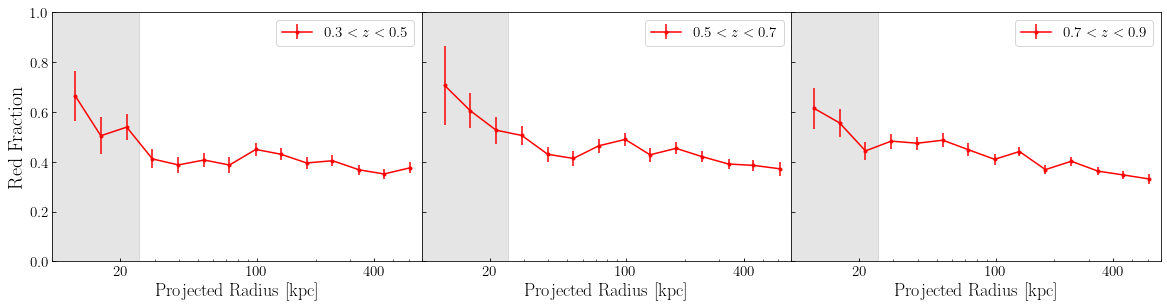

In [54]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,4))

red_frac_4 = count_radial_4_q[0] / count_radial_4[0]
red_frac_6 = count_radial_6_q[0] / count_radial_6[0]
red_frac_8 = count_radial_8_q[0] / count_radial_8[0]

red_err_4 = red_frac_err(count_radial_4_q[0],count_radial_4_sf[0],count_radial_4_q[1],count_radial_4_sf[1])
red_err_6 = red_frac_err(count_radial_6_q[0],count_radial_6_sf[0],count_radial_6_q[1],count_radial_6_sf[1])
red_err_8 = red_frac_err(count_radial_8_q[0],count_radial_8_sf[0],count_radial_8_q[1],count_radial_8_sf[1])

axs[0].errorbar(bin_edges, red_frac_4,yerr=red_err_4,fmt='.-r',label=r'$0.3<z<0.5$')
axs[1].errorbar(bin_edges, red_frac_6,yerr=red_err_6,fmt='.-r',label=r'$0.5<z<0.7$')
axs[2].errorbar(bin_edges, red_frac_8,yerr=red_err_8,fmt='.-r',label=r'$0.7<z<0.9$')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axs[0].set_xlabel('Projected Radius [kpc]', fontsize=18)
axs[1].set_xlabel('Projected Radius [kpc]', fontsize=18)
axs[2].set_xlabel('Projected Radius [kpc]', fontsize=18)

axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xscale('log')
axs[0].set_xlim([9,700])
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_ylim([0,1])
axs[0].set_ylabel('Red Fraction',fontsize=20)
plt.savefig('figures/number_density_zdependence_'+model+'.red_frac.png',dpi=150)

## compare with Illustris-TNG simulation

r_s obs 290.33490291439205 26.29248152913674
r_s sim 224.70545806852752 46.25621917181104


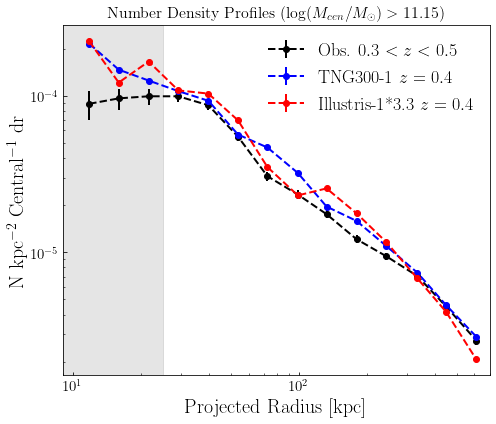

In [52]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))

# count_radial_sim = np.load('TNG_z0_radial.npy')
count_radial_sim = np.load('radial_tot_0.4.npy')  
count_radial_il = np.load('radial_tot_il_0.4.npy')  
count_radial_sim = count_radial_sim/areas/779
count_radial_tal = np.genfromtxt('tal.txt')
count_radial_har = np.genfromtxt('hartley.txt')

plt.errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='--ok',label=r'Obs. $0.3<z<0.5$',linewidth=2)
plt.errorbar(bin_edges, count_radial_sim,0,fmt='--ob',linewidth=2,label=r'TNG300-1 $z=0.4$')
plt.errorbar(bin_edges, count_radial_il*3.3,0,fmt='--or',linewidth=2,label=r'Illustris-1*3.3 $z=0.4$')

fit_x = np.linspace(2,700,num=100)

# m_h from Leathaud et al. 2012
# for rs in [106.4,119.4,153.0]:
#     norm_guess = 1e-4
#     norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-10]/count_radial_4[0][-1])
#     plt.plot(fit_x,nfw(fit_x,rs,norm),':g',linewidth=2)

# m_h from Coupon et al. 2015
# for rs in [134.4,145.4,177.0]:
#     norm_guess = 1e-4
#     norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-10]/count_radial_4[0][-1])
#     plt.plot(fit_x,nfw(fit_x,rs,norm),':y',linewidth=2)

# fitting
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt_sim,pcov_sim,chi2_sim = fit_nfw_sersic(bin_edges,count_radial_sim,count_radial_4[1], start)
print('r_s obs',popt4[0],np.sqrt(np.diag(pcov4))[0])
print('r_s sim',popt_sim[0],np.sqrt(np.diag(pcov_sim))[0])

# shade region

plt.axvspan(9, 25, alpha=0.1, color='k')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Profiles ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.legend(fontsize=18,frameon=False)
plt.tight_layout()
plt.savefig('figures/TNG_Obs_compare.png')

r_s obs 290.33490291439205 26.29248152913674
r_s sim 224.70545806852752 46.25621917181104


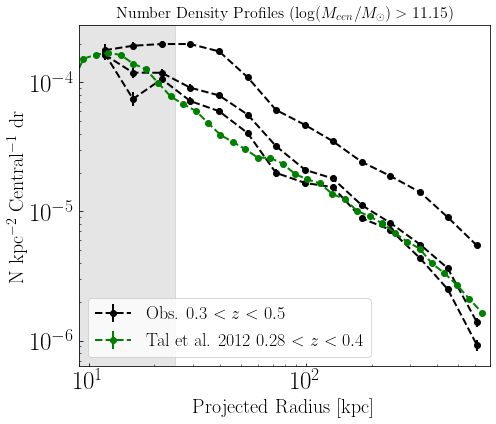

In [16]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(7, 6))

# count_radial_sim = np.load('TNG_z0_radial.npy')
count_radial_sim = np.load('radial_tot_0.4.npy')  
count_radial_il = np.load('radial_tot_il_0.4.npy')  
count_radial_sim = count_radial_sim/areas/779
count_radial_tal = np.genfromtxt('tal.txt')
count_radial_har = np.genfromtxt('hartley.txt')

path = 'CUT_deep_catalogs/total_sample/'
count_radial_41 = combine_deep(csfq,'all','9.5','13.0',0.4,path)
count_radial_42 = combine_deep(csfq,'all','10.0','13.0',0.4,path)
count_radial_43 = combine_deep(csfq,'all','10.2','13.0',0.4,path)
plt.errorbar(bin_edges, count_radial_41[0]*2,count_radial_41[1],fmt='--ok',linewidth=2)
plt.errorbar(bin_edges, count_radial_42[0]*2,count_radial_42[1],fmt='--ok',linewidth=2)
plt.errorbar(bin_edges, count_radial_43[0]*2,count_radial_43[1],fmt='--ok',label=r'Obs. $0.3<z<0.5$',linewidth=2)

# plt.errorbar(bin_edges, count_radial_sim,0,fmt='--ob',linewidth=2,label=r'TNG300-1 $z=0.4$')
# plt.errorbar(bin_edges, count_radial_il*3.3,0,fmt='--or',linewidth=2,label=r'Illustris-1 $z=0.4$')
plt.errorbar(count_radial_tal[:,0], count_radial_tal[:,1],0,fmt='--og',linewidth=2,label=r'Tal et al. 2012 $0.28<z<0.4$')
# plt.errorbar(count_radial_har[:,0], count_radial_har[:,1],0,fmt='--oy',linewidth=2,label=r'Hartley et al. 2015 $0.4<z<1.3$')

# fitting
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt_sim,pcov_sim,chi2_sim = fit_nfw_sersic(bin_edges,count_radial_sim,count_radial_4[1], start)
print('r_s obs',popt4[0],np.sqrt(np.diag(pcov4))[0])
print('r_s sim',popt_sim[0],np.sqrt(np.diag(pcov_sim))[0])

# shade region

plt.axvspan(9, 25, alpha=0.1, color='k')

plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Profiles ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('figures/Obs_liter_compare.png')


In [17]:
a=np.random.rand(3,3)
a

a[:,[0,2]]

array([[0.093, 0.399],
       [0.299, 0.128],
       [0.349, 0.643]])

## Split for Satellite Mass

In [18]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

# move value<=0 to 1e-10 to avoid bad behavior from plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

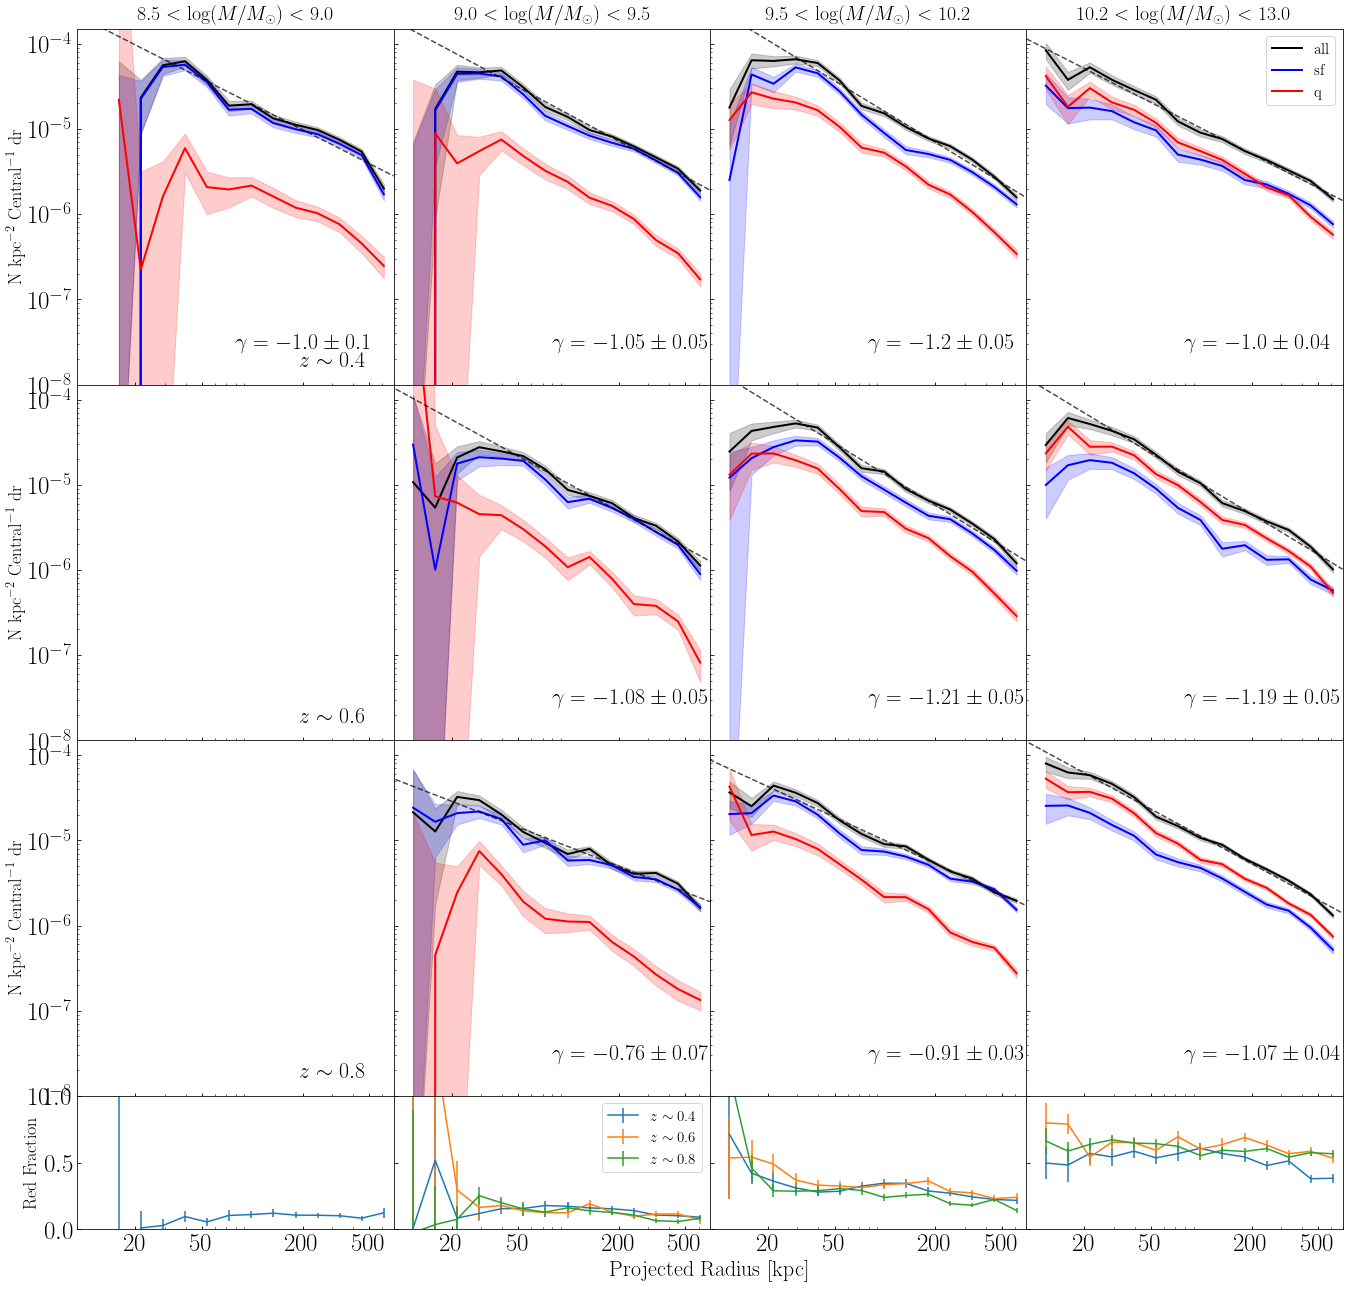

In [19]:
path_old = 'CUT_deep_catalogs/split_sat_mass_new/'
path = 'CUT_deep_catalogs/split_sat_mass_newer/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead

fig, axs = plt.subplots(4, 4, sharex=True, sharey='row', figsize = (20, 18.5),
                        gridspec_kw={'height_ratios':[4,4,4,1.5]})

bin_centers = np.load(path+'bin_centers.npy')
for i in range(3):
    z = i*0.2 + 0.4
    axs[i][0].annotate('$z\sim'+str(round(z,1))+'$',xy=(0.7,0.05),xycoords='axes fraction',fontsize=22)
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [8.5,9.0,9.5,10.2,13.0]
    for j in range(4):
        if i==0 and j==0:
            axs[0][j].set_title('$8.5<\log(M/M_\odot)<9.0$',fontsize=20)
            radial_all = combine_deep('all','all','8.5','9.0', 0.3, path=path_old) 
            radial_sf = combine_deep('all','ssf','8.5','9.0', 0.3, path=path_old)
            radial_q = combine_deep('all','sq','8.5','9.0', 0.3, path=path_old)
        elif j==0:
            continue
        else:
            axs[0][j].set_title('$'+str(mass_range[j])+'<\log(M/M_\odot)<'+str(mass_range[j+1])+'$',fontsize=20)
            radial_all = combine_deep('all','all',str(mass_range[j]),str(mass_range[j+1]), z, path=path) 
            radial_sf = combine_deep('all','ssf',str(mass_range[j]),str(mass_range[j+1]), z, path=path)
            radial_q = combine_deep('all','sq',str(mass_range[j]),str(mass_range[j+1]), z, path=path)
        
        fit_x = np.linspace(2,700,num=100)
        popt,pcov,chi2 = fit_power(bin_centers,radial_all[0],radial_all[1], start=5)
        perr = np.sqrt(np.diag(pcov))
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        axs[i][j].plot(bin_centers, radial_all[0],color='k',linewidth=2,label='all')
        axs[i][j].fill_between(bin_centers,radial_all[0]+radial_all[1],
                               aa(radial_all[0]-radial_all[1]), alpha=0.2, color='k')
        
        axs[i][j].plot(bin_centers, radial_sf[0],color='b',linewidth=2,label='sf')
        axs[i][j].fill_between(bin_centers,radial_sf[0]+radial_sf[1],
                               aa(radial_sf[0]-radial_sf[1]), alpha=0.2, color='b')
        
        axs[i][j].plot(bin_centers, radial_q[0],color='r',linewidth=2,label='q')
        axs[i][j].fill_between(bin_centers,radial_q[0]+radial_q[1],
                               aa(radial_q[0]-radial_q[1]), alpha=0.2, color='r')
        
        axs[i][j].plot(fit_x,power_law(fit_x, popt[0],popt[1]),'--k',alpha=0.7)
        axs[i][j].annotate('$\gamma='+str(round(popt[1],2))+'\pm'+str(round(perr[1],2))+'$',
                           xy=(0.5,0.1),xycoords='axes fraction',fontsize=22)
        
        axs[3][j].errorbar(bin_edges, red_frac,yerr=red_err,label='$z\sim'+str(round(z,1))+'$')

#=============================
axs[0][0].set_ylim([1e-8,1.5e-4])
axs[0][0].set_xlim([9,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')

axs[1][0].set_ylim([1e-8,1.5e-4])
axs[1][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[2][0].set_ylim([1e-8,1.5e-4])
axs[2][0].set_yscale('log')
axs[2][0].set_xscale('log')

axs[3][0].set_ylim([0,1])
axs[0][0].set_xticks([20, 50, 200, 500])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[3][0].set_ylabel('Red Fraction',fontsize=18)
axs[0][3].legend(fontsize=15)
axs[3][1].legend(fontsize=15)
        
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=22)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_mass_redfraction.png')
plt.show()

In [20]:
# combine redshift bins

path = 'CUT_deep_catalogs/split_sat_mass_newer/'

radial_all = np.zeros(14)
radial_all_err_square = np.zeros(14)
radial_ssf = np.zeros(14)
radial_ssf_err_square = np.zeros(14)
radial_sq = np.zeros(14)
radial_sq_err_square = np.zeros(14)
count_all = 0
count_ssf = 0
count_sq = 0
for z in [0.4, 0.6, 0.8]:
    masscut_lim = [9.5, 10.2]
#     masscut_lim = [10.2,13.0]
    for masslow_id in range(len(masscut_lim)-1):
        print(masscut_lim[masslow_id])
        radial_z_all = combine_deep('all','all',str(masscut_lim[masslow_id]),str(masscut_lim[masslow_id+1]), z, path=path)
        count_all += radial_z_all[2]
        radial_all += radial_z_all[0]*radial_z_all[2]
        radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
        radial_z_ssf = combine_deep('all','ssf',str(masscut_lim[masslow_id]),str(masscut_lim[masslow_id+1]), z, path=path)
        count_ssf += radial_z_ssf[2]
        radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
        radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
        radial_z_sq = combine_deep('all','sq',str(masscut_lim[masslow_id]),str(masscut_lim[masslow_id+1]), z, path=path)
        count_sq += radial_z_sq[2]
        radial_sq += radial_z_sq[0]*radial_z_sq[2]
        radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2

radial_all = (radial_all/count_all,np.sqrt(radial_all_err_square)/count_all)
radial_ssf = (radial_ssf/count_ssf,np.sqrt(radial_ssf_err_square)/count_ssf)
radial_sq = (radial_sq/count_sq,np.sqrt(radial_sq_err_square)/count_sq)

np.savetxt(path+'all_field_'+ str(masscut_lim[0]) + '_all_'+ 'all'+'.txt', radial_all)
np.savetxt(path+'all_field_'+ str(masscut_lim[0]) + '_all_'+ 'ssf'+'.txt', radial_ssf)
np.savetxt(path+'all_field_'+ str(masscut_lim[0]) + '_all_'+ 'sq'+'.txt', radial_sq)
print(path+'all_field_'+ str(masscut_lim[0]) + '_all_'+ 'all'+'.txt')

9.5
9.5
9.5
CUT_deep_catalogs/split_sat_mass_newer/all_field_9.5_all_all.txt


[3.450e+02 1.039e-05 2.456e-05 3.068e+01 2.103e-01] [1.870e+01 6.055e-07 2.004e-06 4.921e+00 8.191e-02] Chi2_dof=0.74
[5.058e+02 5.513e-06 1.909e-05 3.425e+01 3.478e-01] [5.596e+01 5.966e-07 2.734e-06 2.234e+00 1.430e-01] Chi2_dof=1.85
[1.759e+02 5.759e-06 6.103e-06 2.850e+01 1.989e-01] [1.490e+01 6.384e-07 1.273e-06 1.445e+01 1.789e-01] Chi2_dof=0.96
[3.384e+02 9.043e-06 2.187e-05 3.137e+01 7.614e-01] [3.500e+01 1.077e-06 6.710e-06 4.701e+00 4.929e-01] Chi2_dof=1.71
[4.184e+02 3.088e-06 8.103e-06 3.163e+01 1.036e+00] [7.668e+01 6.322e-07 5.203e-06 1.016e+01 1.308e+00] Chi2_dof=1.75
[2.607e+02 6.873e-06 1.453e-05 2.975e+01 6.430e-01] [2.478e+01 8.020e-07 4.851e-06 4.564e+00 4.349e-01] Chi2_dof=1.24


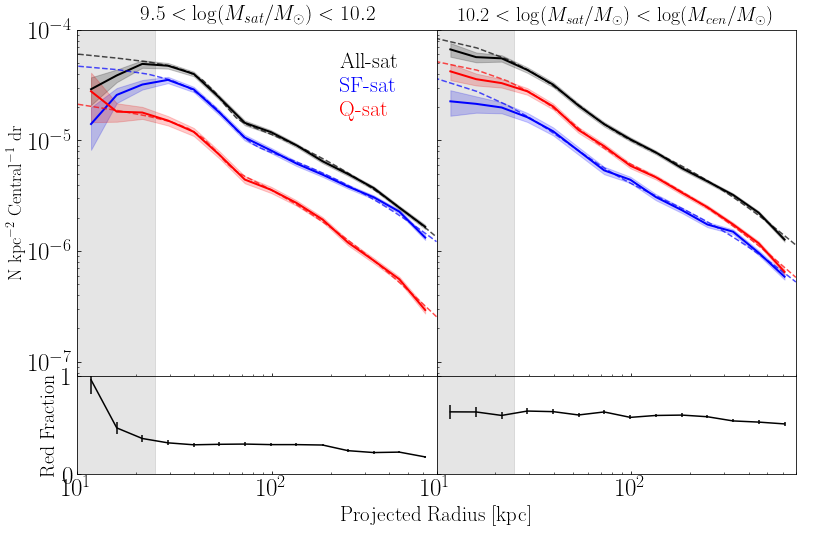

In [21]:
# combine redshift bins
np.set_printoptions(precision=3)
start=4

path = 'CUT_deep_catalogs/split_sat_mass_allz/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead

fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize = (12, 8),
                        gridspec_kw={'height_ratios':[3.5,1]})

bin_centers = np.load(path+'bin_centers.npy')
for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [9.5,10.2,13.0]
    for j in range(2):
        radial_all = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_all.txt')
        radial_sf = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_ssf.txt')
        radial_q = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_sq.txt')
        
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        # plot radial number density profiles
        for radial,color,yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].plot(bin_centers, radial[0],color=color,linewidth=2,label='all')
            axs[i][j].fill_between(bin_centers,radial[0]+radial[1],
                                   aa(radial[0]-radial[1]), alpha=0.2, color=color)
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)        
            popt,pcov,chi2 = fit_nfw_sersic(bin_edges,radial[0],radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            dof = len(bin_edges)-start+1 - len(popt) # degree of freedom
            print(popt,perr,'Chi2_dof='+str(round(chi2/dof,2)))

#             axs[i][j].annotate('$\chi^2_\mathrm{dof}$ = '+str(round(chi2/dof,2)),
#                                xy=([0.23,yloc]),xycoords='axes fraction',fontsize=18,color=color)
            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
        
        # red fraction
        axs[1][j].errorbar(bin_edges, red_frac,yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,1e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Red Fraction',fontsize=20)

axs[0][0].set_title('$9.5<\log(M_{sat}/M_\odot)<10.2$',fontsize=21)
axs[0][1].set_title('$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',fontsize=20)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
     
# axs[1][0].plot([10,700],[0.18,0.18],linewidth=2,color='g')
# axs[1][1].plot([10,700],[0.47,0.47],linewidth=2,color='g')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_sat_mass_allz.png')
plt.show()
plt.close()

[2.424e+02 1.087e-05 1.715e-05 3.037e+01 2.422e-01] [3.037e+01 1.621e-06 4.014e-06 5.389e+00 2.329e-01] Chi2_dof=3.81
[2.698e+02 7.165e-06 1.258e-05 3.155e+01 2.411e-01] [4.689e+01 1.452e-06 3.532e-06 7.851e+00 2.855e-01] Chi2_dof=4.5
[1.606e+02 4.225e-06 3.449e-06 2.842e+01 1.959e-01] [1.694e+01 5.900e-07 9.800e-07 2.313e+01 2.471e-01] Chi2_dof=1.03
[2.358e+02 8.724e-06 1.158e-05 3.300e+01 6.022e-01] [3.843e+01 1.800e-06 4.754e-06 6.943e+00 6.375e-01] Chi2_dof=3.32
[2.809e+02 3.964e-06 6.744e-06 3.169e+01 4.783e-01] [4.534e+01 7.566e-07 2.723e-06 6.083e+00 5.169e-01] Chi2_dof=2.12
[1.578e+02 6.561e-06 3.903e-06 3.332e+01 3.372e-01] [2.265e+01 1.278e-06 1.663e-06 6.124e+00 4.122e-01] Chi2_dof=1.88
[1.958e+02 7.638e-06 8.893e-06 2.747e+01 2.158e-01] [2.958e+01 1.438e-06 3.485e-06 9.297e+00 2.471e-01] Chi2_dof=4.04
[2.328e+02 2.178e-06 2.495e-06 3.130e+01 3.524e-01] [3.266e+01 3.744e-07 9.494e-07 5.007e+00 4.185e-01] Chi2_dof=0.83
[1.289e+02 8.425e-06 2.189e-04 6.097e-01 1.444e+00] [2.35

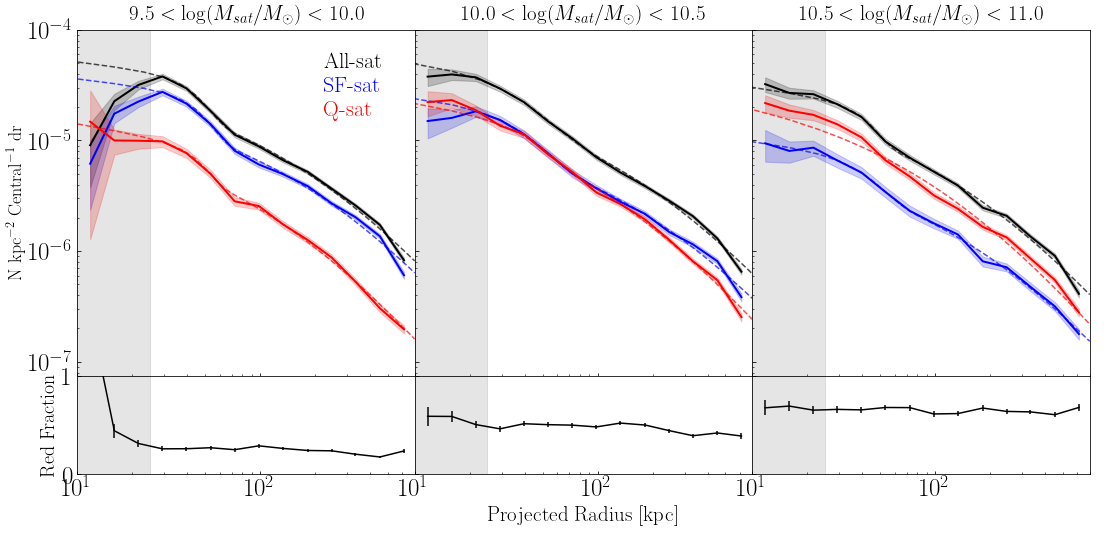

In [22]:
# combine redshift bins
np.set_printoptions(precision=3)
start=4
path = 'CUT_deep_catalogs/split_sat_mass_3bins/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead

fig, axs = plt.subplots(2, 3, sharex=True, sharey='row', figsize = (16, 8),
                        gridspec_kw={'height_ratios':[3.5,1]})

bin_centers = np.load(path+'bin_centers.npy')
for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [9.5,10.0,10.5,11.0]
    for j in range(3):
        axs[0][j].set_title('$'+str(mass_range[j])+'<\log(M_{sat}/M_\odot)<'+str(mass_range[j+1])+'$',fontsize=21)
        radial_all = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_all.txt')
        radial_sf = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_ssf.txt')
        radial_q = np.genfromtxt(path+'all_field_'+str(mass_range[j])+'_all_sq.txt')
        
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        # plot radial number density profiles
        for radial,color,yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].plot(bin_centers, radial[0],color=color,linewidth=2,label='all')
            axs[i][j].fill_between(bin_centers,radial[0]+radial[1],
                                   aa(radial[0]-radial[1]), alpha=0.2, color=color)
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)        
            popt,pcov,chi2 = fit_nfw_sersic(bin_edges,radial[0],radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            dof = len(bin_edges)-start+1 - len(popt) # degree of freedom
            print(popt,perr,'Chi2_dof='+str(round(chi2/dof,2)))

            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
        
        # red fraction
        axs[1][j].errorbar(bin_edges, red_frac,yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,1e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Red Fraction',fontsize=20)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
     
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_sat_mass_allz_3bins.png')
plt.show()
plt.close()

## Galaxy Conformity

redfraction [0.619 0.546 0.539 0.444 0.483 0.431 0.448 0.435 0.415 0.415 0.405 0.367
 0.362 0.346]
Q-frac for csf 0.294 0.015
Q-frac for cq 0.364 0.007


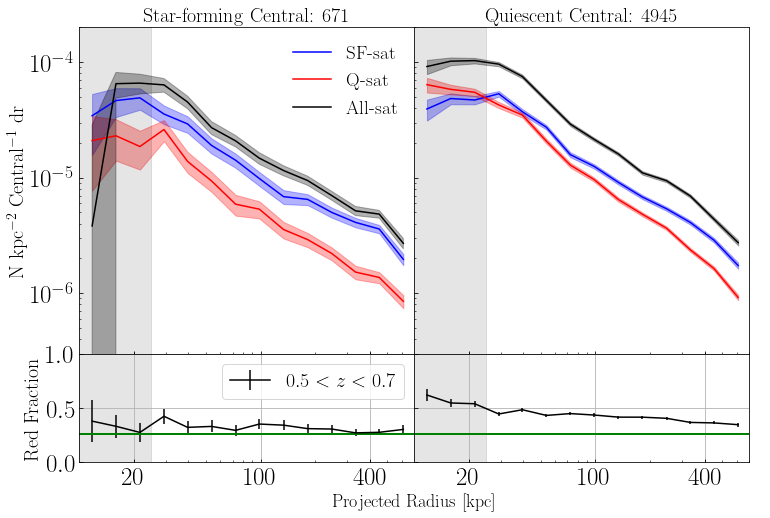

In [85]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey='row', figsize=(12, 8),gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

path = 'CUT_deep_catalogs/conformity_sfProb/'
z = 0.6

radial_csf_ssf_6 = combine_deep('csf','ssf','9.5','inf',z, path)
radial_csf_sq_6 = combine_deep('csf','sq','9.5','inf',z, path)
radial_csf_6 = combine_deep('csf','all','9.5','inf',z, path)

radial_cq_ssf_6 = combine_deep('cq','ssf','9.5','inf',z, path)
radial_cq_sq_6 = combine_deep('cq','sq','9.5','inf',z, path)
radial_cq_6 = combine_deep('cq','all','9.5','inf',z, path)

redfrac_err_csf_6 = red_frac_err(radial_csf_sq_6[0],radial_csf_ssf_6[0],radial_csf_sq_6[1],radial_csf_ssf_6[1])
redfrac_err_cq_6 = red_frac_err(radial_cq_sq_6[0],radial_cq_ssf_6[0],radial_cq_sq_6[1],radial_cq_ssf_6[1])

bin_centers = np.load(path+'bin_centers.npy')

axs[0][0].errorbar(bin_centers, radial_csf_ssf_6[0], fmt='b',label='SF-sat')
axs[0][0].errorbar(bin_centers, radial_csf_sq_6[0], fmt='r',label='Q-sat')
axs[0][0].errorbar(bin_centers, radial_csf_6[0], yerr=None, fmt='k',label='All-sat')
axs[0][0].fill_between(bin_centers,radial_csf_ssf_6[0]+radial_csf_ssf_6[1], 
                       radial_csf_ssf_6[0]-radial_csf_ssf_6[1], alpha=0.3,color='b')
axs[0][0].fill_between(bin_centers,radial_csf_sq_6[0]+radial_csf_sq_6[1], 
                       radial_csf_sq_6[0]-radial_csf_sq_6[1], alpha=0.3,color='r')
axs[0][0].fill_between(bin_centers,radial_csf_6[0]+radial_csf_6[1], 
                       radial_csf_6[0]-radial_csf_6[1], alpha=0.3,color='k')

axs[0][0].legend(fontsize=19,frameon=False)
axs[0][1].errorbar(bin_centers, radial_cq_ssf_6[0], yerr=None, fmt='b')
axs[0][1].errorbar(bin_centers, radial_cq_sq_6[0], yerr=None, fmt='r')
axs[0][1].errorbar(bin_centers, radial_cq_6[0], yerr=None, fmt='k')
axs[0][1].fill_between(bin_centers,radial_cq_ssf_6[0]+radial_cq_ssf_6[1], 
                       radial_cq_ssf_6[0]-radial_cq_ssf_6[1], alpha=0.3,color='b')
axs[0][1].fill_between(bin_centers,radial_cq_sq_6[0]+radial_cq_sq_6[1], 
                       radial_cq_sq_6[0]-radial_cq_sq_6[1], alpha=0.3,color='r')
axs[0][1].fill_between(bin_centers,radial_cq_6[0]+radial_cq_6[1], 
                       radial_cq_6[0]-radial_cq_6[1], alpha=0.3,color='k')


axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=20)
axs[0][0].set_title('Star-forming Central: '+str(radial_csf_6[2]),fontsize=20)
axs[0][1].set_title('Quiescent Central: '+str(radial_cq_6[2]),fontsize=20)


red_frac_sf = radial_csf_sq_6[0]/(radial_csf_sq_6[0]+radial_csf_ssf_6[0])
red_frac_q = radial_cq_sq_6[0]/(radial_cq_sq_6[0]+radial_cq_ssf_6[0])
np.set_printoptions(precision=3)
print('redfraction',red_frac_q)
print('Q-frac for csf',round(np.average(red_frac_sf[2:],weights=areas[2:]),3),round(np.sqrt(sum(redfrac_err_csf_6[2:]**2))/len(redfrac_err_csf_6[2:]**2),3))
print('Q-frac for cq',round(np.average(red_frac_q,weights=areas),3),round(np.sqrt(sum(redfrac_err_cq_6**2))/len(redfrac_err_cq_6**2),3))

axs[1][0].errorbar(bin_centers, red_frac_sf, fmt='k',yerr=redfrac_err_csf_6,label=r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$')
axs[1][1].errorbar(bin_centers, red_frac_q, fmt='k',yerr=redfrac_err_cq_6)

q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(z*10%2)-1]

axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][0].set_ylabel('Red Fraction',fontsize=20)

axs[1][0].legend(fontsize=20)
axs[1][0].set_ylabel('Red Fraction', fontsize=20)

# popt_csf = fit_nfw_sersic(bin_edges,radial_csf_6[0],radial_csf_6[1])
# popt_cq = fit_nfw_sersic(bin_edges,radial_cq_6[0],radial_cq_6[1])


# axs[0][0].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_csf[0],popt_csf[1],popt_csf[2],popt_csf[3])
#                ,'--k',alpha=0.7,label='NFW fit')
# axs[0][1].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_cq[0],popt_cq[1],popt_cq[2],popt_cq[3]),'--k',alpha=0.7,label='NFW fit')

axs[0][0].set_xlim([10,700])
axs[0][0].set_ylim([3e-7,2e-4])
axs[1][0].set_ylim([0,1])
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log') 
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[1][0].grid(True)
axs[1][1].grid(True)

# add shaded (non-fitting) region
axs[0][0].axvspan(10, 25, alpha=0.1, color='k')
axs[0][1].axvspan(10, 25, alpha=0.1, color='k')
axs[1][0].axvspan(10, 25, alpha=0.1, color='k')
axs[1][1].axvspan(10, 25, alpha=0.1, color='k')

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/splitting_central_sfq_'+str(z)+'.png')
plt.show()

redfraction [0.642 0.511 0.549 0.367 0.4   0.392 0.401 0.471 0.452 0.42  0.383 0.405
 0.364 0.352]
Q-frac for csf 0.124 0.079
Q-frac for cq 0.371 0.015


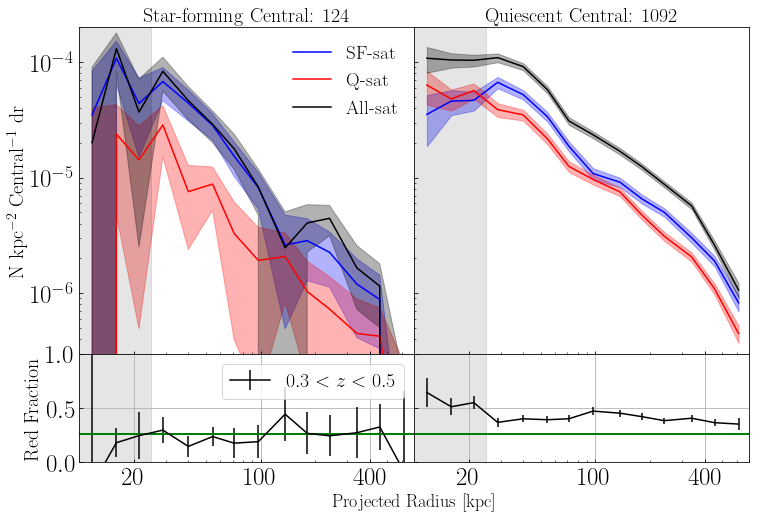

In [25]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey='row', figsize=(12, 8),gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

path = 'CUT_deep_catalogs/conformity_sfProb_6/'
z = 0.4

radial_csf_ssf_6 = combine_deep('csf','ssf','9.5','inf',z, path)
radial_csf_sq_6 = combine_deep('csf','sq','9.5','inf',z, path)
radial_csf_6 = combine_deep('csf','all','9.5','inf',z, path)

radial_cq_ssf_6 = combine_deep('cq','ssf','9.5','inf',z, path)
radial_cq_sq_6 = combine_deep('cq','sq','9.5','inf',z, path)
radial_cq_6 = combine_deep('cq','all','9.5','inf',z, path)

redfrac_err_csf_6 = red_frac_err(radial_csf_sq_6[0],radial_csf_ssf_6[0],radial_csf_sq_6[1],radial_csf_ssf_6[1])
redfrac_err_cq_6 = red_frac_err(radial_cq_sq_6[0],radial_cq_ssf_6[0],radial_cq_sq_6[1],radial_cq_ssf_6[1])

bin_centers = np.load(path+'bin_centers.npy')

axs[0][0].errorbar(bin_centers, radial_csf_ssf_6[0], fmt='b',label='SF-sat')
axs[0][0].errorbar(bin_centers, radial_csf_sq_6[0], fmt='r',label='Q-sat')
axs[0][0].errorbar(bin_centers, radial_csf_6[0], yerr=None, fmt='k',label='All-sat')
axs[0][0].fill_between(bin_centers,radial_csf_ssf_6[0]+radial_csf_ssf_6[1], 
                       radial_csf_ssf_6[0]-radial_csf_ssf_6[1], alpha=0.3,color='b')
axs[0][0].fill_between(bin_centers,radial_csf_sq_6[0]+radial_csf_sq_6[1], 
                       radial_csf_sq_6[0]-radial_csf_sq_6[1], alpha=0.3,color='r')
axs[0][0].fill_between(bin_centers,radial_csf_6[0]+radial_csf_6[1], 
                       radial_csf_6[0]-radial_csf_6[1], alpha=0.3,color='k')

axs[0][0].legend(fontsize=19,frameon=False)
axs[0][1].errorbar(bin_centers, radial_cq_ssf_6[0], yerr=None, fmt='b')
axs[0][1].errorbar(bin_centers, radial_cq_sq_6[0], yerr=None, fmt='r')
axs[0][1].errorbar(bin_centers, radial_cq_6[0], yerr=None, fmt='k')
axs[0][1].fill_between(bin_centers,radial_cq_ssf_6[0]+radial_cq_ssf_6[1], 
                       radial_cq_ssf_6[0]-radial_cq_ssf_6[1], alpha=0.3,color='b')
axs[0][1].fill_between(bin_centers,radial_cq_sq_6[0]+radial_cq_sq_6[1], 
                       radial_cq_sq_6[0]-radial_cq_sq_6[1], alpha=0.3,color='r')
axs[0][1].fill_between(bin_centers,radial_cq_6[0]+radial_cq_6[1], 
                       radial_cq_6[0]-radial_cq_6[1], alpha=0.3,color='k')


axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=20)
axs[0][0].set_title('Star-forming Central: '+str(radial_csf_6[2]),fontsize=20)
axs[0][1].set_title('Quiescent Central: '+str(radial_cq_6[2]),fontsize=20)


red_frac_sf = radial_csf_sq_6[0]/(radial_csf_sq_6[0]+radial_csf_ssf_6[0])
red_frac_q = radial_cq_sq_6[0]/(radial_cq_sq_6[0]+radial_cq_ssf_6[0])
np.set_printoptions(precision=3)
print('redfraction',red_frac_q)
print('Q-frac for csf',round(np.average(red_frac_sf[2:],weights=areas[2:]),3),round(np.sqrt(sum(redfrac_err_csf_6[2:]**2))/len(redfrac_err_csf_6[2:]**2),3))
print('Q-frac for cq',round(np.average(red_frac_q,weights=areas),3),round(np.sqrt(sum(redfrac_err_cq_6**2))/len(redfrac_err_cq_6**2),3))

axs[1][0].errorbar(bin_centers, red_frac_sf, fmt='k',yerr=redfrac_err_csf_6,label=r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$')
axs[1][1].errorbar(bin_centers, red_frac_q, fmt='k',yerr=redfrac_err_cq_6)

q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(z*10%2)-1]

axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][0].set_ylabel('Red Fraction',fontsize=20)

axs[1][0].legend(fontsize=20)
axs[1][0].set_ylabel('Red Fraction', fontsize=20)

# popt_csf = fit_nfw_sersic(bin_edges,radial_csf_6[0],radial_csf_6[1])
# popt_cq = fit_nfw_sersic(bin_edges,radial_cq_6[0],radial_cq_6[1])


# axs[0][0].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_csf[0],popt_csf[1],popt_csf[2],popt_csf[3])
#                ,'--k',alpha=0.7,label='NFW fit')
# axs[0][1].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_cq[0],popt_cq[1],popt_cq[2],popt_cq[3]),'--k',alpha=0.7,label='NFW fit')

axs[0][0].set_xlim([10,700])
axs[0][0].set_ylim([3e-7,2e-4])
axs[1][0].set_ylim([0,1])
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log') 
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[1][0].grid(True)
axs[1][1].grid(True)

# add shaded (non-fitting) region
axs[0][0].axvspan(10, 25, alpha=0.1, color='k')
axs[0][1].axvspan(10, 25, alpha=0.1, color='k')
axs[1][0].axvspan(10, 25, alpha=0.1, color='k')
axs[1][1].axvspan(10, 25, alpha=0.1, color='k')

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/splitting_central_sfq_'+str(z)+'.png')

## Stack profiles from all redshifts
split for quiescent and star-forming centrals

In [83]:
path = 'CUT_deep_catalogs/conformity_sfProb/'

radial_csf_ssf = np.zeros(14)
radial_csf_ssf_err = np.zeros(14)
radial_csf_sq = np.zeros(14)
radial_csf_sq_err = np.zeros(14)
radial_csf = np.zeros(14)
radial_csf_err = np.zeros(14)
radial_cq_ssf = np.zeros(14)
radial_cq_ssf_err = np.zeros(14)
radial_cq_sq = np.zeros(14)
radial_cq_sq_err = np.zeros(14)
radial_cq = np.zeros(14)
radial_cq_err = np.zeros(14)

count_csf = 0
count_cq = 0

for z in [0.4,0.6,0.8]:
    radial_csf_ssf_z = combine_deep('csf','ssf','9.5','inf',z, path)
    radial_csf_sq_z = combine_deep('csf','sq','9.5','inf',z, path)
    radial_csf_z = combine_deep('csf','all','9.5','inf',z, path)

    radial_cq_ssf_z = combine_deep('cq','ssf','9.5','inf',z, path)
    radial_cq_sq_z = combine_deep('cq','sq','9.5','inf',z, path)
    radial_cq_z = combine_deep('cq','all','9.5','inf',z, path)
    
    # csf, ssf
    radial_csf_ssf += radial_csf_ssf_z[0]*radial_csf_z[2]
    radial_csf_ssf_err += radial_csf_ssf_z[1]**2*radial_csf_ssf_z[2]**2
    
    # csf, sq
    radial_csf_sq += radial_csf_sq_z[0]*radial_csf_z[2]
    radial_csf_sq_err += radial_csf_sq_z[1]**2*radial_csf_ssf_z[2]**2
    
    #csf, all
    count_csf += radial_csf_z[2]
    radial_csf += radial_csf_z[0]*radial_csf_z[2]
    radial_csf_err += radial_csf_z[1]**2*radial_csf_ssf_z[2]**2
    
    #cq, ssf
    radial_cq_ssf += radial_cq_ssf_z[0]*radial_cq_z[2]
    radial_cq_ssf_err += radial_cq_ssf_z[1]**2*radial_csf_ssf_z[2]**2
    
    #cq, sq
    radial_cq_sq += radial_cq_sq_z[0]*radial_cq_z[2]
    radial_cq_sq_err += radial_cq_sq_z[1]**2*radial_csf_ssf_z[2]**2
    
    #cq, all
    count_cq += radial_cq_z[2]
    radial_cq += radial_cq_z[0]*radial_cq_z[2]
    radial_cq_err += radial_cq_z[1]**2*radial_csf_ssf_z[2]**2

621.4488810252174 147.9931773089606
366.08265691454125 33.21909822835386


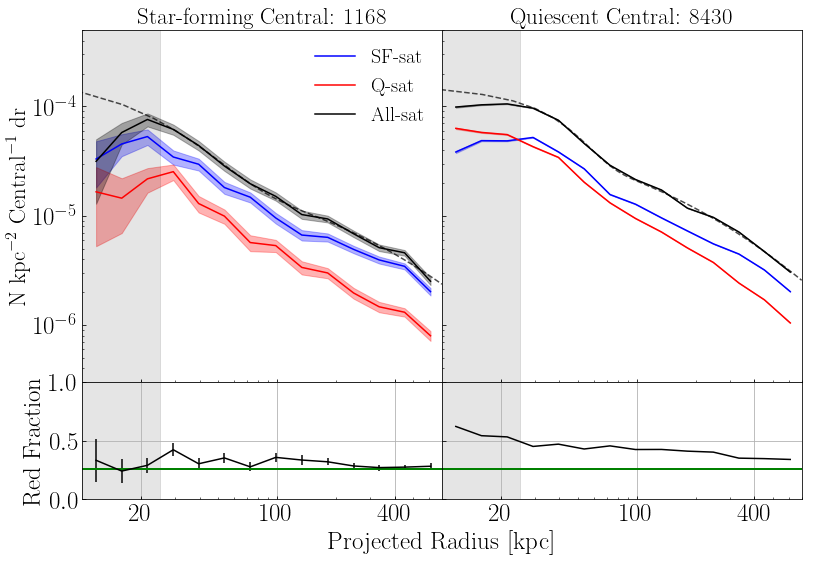

In [84]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey='row', figsize=(12, 8),gridspec_kw={'height_ratios':[3,1]})
# z=0.4

radial_csf_ssf = ( radial_csf_ssf/count_csf, np.sqrt(radial_csf_ssf_err)/count_csf )
radial_csf_sq = (radial_csf_sq/count_csf,np.sqrt(radial_csf_sq_err)/count_csf)
radial_csf = (radial_csf/count_csf,np.sqrt(radial_csf_err)/count_csf)
radial_cq_ssf = (radial_cq_ssf/count_cq,np.sqrt(radial_cq_ssf_err)/count_cq)
radial_cq_sq = (radial_cq_sq/count_cq,np.sqrt(radial_cq_sq_err)/count_cq)
radial_cq = (radial_cq/count_cq,np.sqrt(radial_cq_err)/count_cq)

# radial_csf_ssf = combine_deep('csf', 'ssf', 9.5, 13.0, z, path)
# radial_csf_sq = combine_deep('csf', 'sq', 9.5, 13.0, z, path)
# radial_csf = combine_deep('csf', 'all', 9.5, 13.0, z, path)
# radial_cq_ssf = combine_deep('cq', 'ssf', 9.5, 13.0, z, path)
# radial_cq_sq = combine_deep('cq', 'sq', 9.5, 13.0, z, path)
# radial_cq = combine_deep('cq', 'all', 9.5, 13.0, z, path)
# count_csf = radial_csf[2]
# count_cq = radial_cq[2]

popt_csf,pcov_csf,chi2 = fit_nfw_sersic(bin_edges,radial_csf[0],radial_csf[1], start=4)
popt_cq,pcov_cq,chi2 = fit_nfw_sersic(bin_edges,radial_cq[0],radial_cq[1], start=4)
perr_csf = np.sqrt(np.diag(pcov_csf))
perr_cq = np.sqrt(np.diag(pcov_cq))

print(popt_csf[0],perr_csf[0])
print(popt_cq[0],perr_cq[0])

redfrac_err_csf = red_frac_err(radial_csf_sq[0],radial_csf_ssf[0],radial_csf_sq[1],radial_csf_ssf[1])
redfrac_err_cq = red_frac_err(radial_cq_sq[0],radial_cq_ssf[0],radial_cq_sq[1],radial_cq_ssf[1])
bin_centers = np.load(path+'bin_centers.npy')

#csf
axs[0][0].errorbar(bin_centers, radial_csf_ssf[0], fmt='b',label='SF-sat')
axs[0][0].errorbar(bin_centers, radial_csf_sq[0], fmt='r',label='Q-sat')
axs[0][0].errorbar(bin_centers, radial_csf[0], yerr=None, fmt='k',label='All-sat')
axs[0][0].fill_between(bin_centers,radial_csf_ssf[0]+radial_csf_ssf[1], 
                       radial_csf_ssf[0]-radial_csf_ssf[1], alpha=0.3,color='b')
axs[0][0].fill_between(bin_centers,radial_csf_sq[0]+radial_csf_sq[1], 
                       radial_csf_sq[0]-radial_csf_sq[1], alpha=0.3,color='r')
axs[0][0].fill_between(bin_centers,radial_csf[0]+radial_csf[1], 
                       radial_csf[0]-radial_csf[1], alpha=0.3,color='k')

axs[0][0].plot(fit_x,nfw_sersic(fit_x, popt_csf[0],popt_csf[1],popt_csf[2],popt_csf[3],popt_csf[4]),'--k',alpha=0.7)
axs[0][0].legend(fontsize=20,frameon=False)

# cq
axs[0][1].errorbar(bin_centers, radial_cq_ssf[0], yerr=None, fmt='b')
axs[0][1].errorbar(bin_centers, radial_cq_sq[0], yerr=None, fmt='r')
axs[0][1].errorbar(bin_centers, radial_cq[0], yerr=None, fmt='k')
axs[0][1].fill_between(bin_centers,radial_cq_ssf[0]+radial_cq_ssf[1], 
                       radial_cq_ssf[0]-radial_cq_ssf[1], alpha=0.3,color='b')
axs[0][1].fill_between(bin_centers,radial_cq_sq[0]+radial_cq_sq[1], 
                       radial_cq_sq[0]-radial_cq_sq[1], alpha=0.3,color='r')
axs[0][1].fill_between(bin_centers,radial_cq[0]+radial_cq[1], 
                       radial_cq[0]-radial_cq[1], alpha=0.3,color='k')

axs[0][1].plot(fit_x,nfw_sersic(fit_x, popt_cq[0],popt_cq[1],popt_cq[2],popt_cq[3],popt_cq[4]),'--k',alpha=0.7)

axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=23)
axs[0][0].set_title('Star-forming Central: '+str(count_csf),fontsize=23)
axs[0][1].set_title('Quiescent Central: '+str(count_cq),fontsize=23)


# second row: red fraction
red_frac_sf = radial_csf_sq[0]/(radial_csf_sq[0]+radial_csf_ssf[0])
red_frac_q = radial_cq_sq[0]/(radial_cq_sq[0]+radial_cq_ssf[0])

axs[1][0].errorbar(bin_centers, red_frac_sf, fmt='k',yerr=redfrac_err_csf)
axs[1][1].errorbar(bin_centers, red_frac_q, fmt='k',yerr=redfrac_err_cq)

q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(z*10%2)-1]

axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][0].set_ylabel('Red Fraction',fontsize=25)
axs[1][0].set_ylabel('Red Fraction', fontsize=25)

axs[0][0].set_xlim([10,700])
axs[0][0].set_ylim([3e-7,5e-4])
axs[1][0].set_ylim([0,1])
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log') 
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[1][0].grid(True)
axs[1][1].grid(True)

# add shaded (non-fitting) region
axs[0][0].axvspan(10, 25, alpha=0.1, color='k')
axs[0][1].axvspan(10, 25, alpha=0.1, color='k')
axs[1][0].axvspan(10, 25, alpha=0.1, color='k')
axs[1][1].axvspan(10, 25, alpha=0.1, color='k')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

plt.xlabel('Projected Radius [kpc]', fontsize=25)
plt.savefig('figures/splitting_central_sfq_all_z.png')
plt.show()

### Mass distribution of central sf/q galaxies

KS-test: 0.26086956521739135 0.35991078269860205


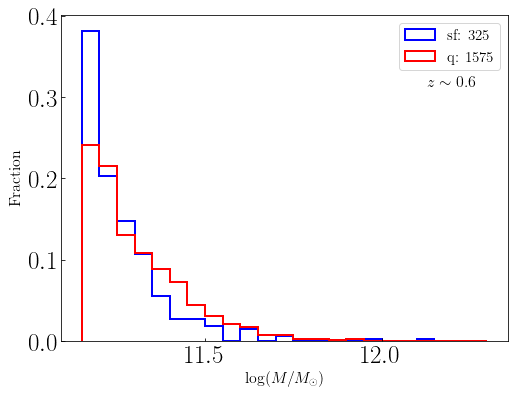

In [28]:
from scipy.stats import ks_2samp
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

sf_mass_list = np.array([])
q_mass_list = np.array([])
for cat_name in ['COSMOS_deep','ELAIS_deep','DEEP_deep','XMM-LSS_deep','SXDS_uddd']:
    cat = Table.read('CUT_deep_catalogs/massive_gal_positions/isolated_'+cat_name+'_11.15_0.6.positions.fits')
    cat_sf = cat[cat['sfProb']>0.4]
    cat_q = cat[cat['sfProb']<0.4]
    sf_mass_list = np.append(sf_mass_list,cat_sf['MASS_MED']) 
    q_mass_list = np.append(q_mass_list,cat_q['MASS_MED'])
    
weights_sf = np.ones_like(sf_mass_list)/float(len(sf_mass_list))
weights_q = np.ones_like(q_mass_list)/float(len(q_mass_list))

n_sf, bin_edges, pathces = plt.hist(sf_mass_list, weights=weights_sf,bins=np.arange(11.15,12.35,0.05),\
         histtype='step',linewidth=2, color='b',label='sf: '+str(len(sf_mass_list)))
n_q, bin_edges, pathces = plt.hist(q_mass_list, weights=weights_q,bins=np.arange(11.15,12.35,0.05),\
         histtype='step',linewidth=2, color='r',label='q: '+str(len(q_mass_list)))

D,p_value = ks_2samp(n_sf, n_q)
print('KS-test:',D,p_value)

plt.ylabel('Fraction',fontsize=16)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=16)
plt.annotate(r'$z\sim0.6$',xy=(0.82,0.78),xycoords='axes fraction',fontsize=16)
plt.legend(fontsize=15)
plt.savefig('figures/central_11.15_hist.png')
plt.show()

## Link Through Redshift

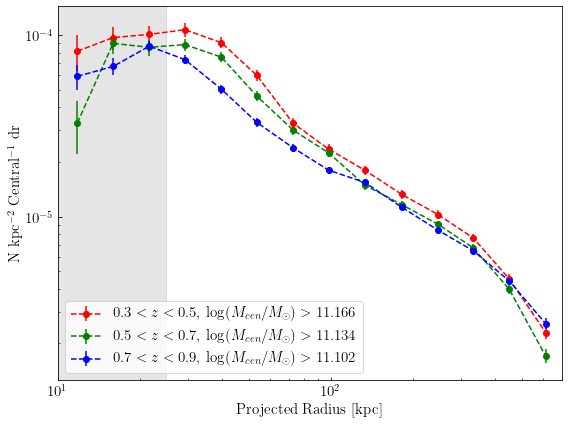

In [51]:
# combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path)

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

path = 'CUT_deep_catalogs/ltr/'  # evolving mass cut
slope = 0.16
masscut_z0 = 11.23
masscut_type = 'evolving'

# path = 'CUT_deep_catalogs/total_sample/' # constant mass cut
# slope = 0
# masscut_z0 = 11.15
# masscut_type = 'constant'

# radial_2 = combine_deep('all','all','9.5','inf',0.2, path)
radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

# plt.errorbar(bin_centers, radial_2[0],yerr=radial_2[1],label='$z\sim0.2$')
plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or--',label='$0.3<z<0.5$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.4)+'$')
plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og--',label='$0.5<z<0.7$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.6)+'$')
plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob--',label='$0.7<z<0.9$, $\log (M_{cen}/M_\odot)>'+str(masscut_z0-slope*0.8)+'$')
plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,700])

plt.tight_layout()
plt.savefig('figures/radial_evolution_'+masscut_type+'_masscut.png')
plt.show()

## Central Mass Dependence

In [57]:
# no return for central_num
def combine_deep_new(masscut_h_low,z,csfq, ssfq,path='CUT_deep_catalogs/'):
    affix = '_host_'+str(masscut_h_low)+'_9.5_'+csfq+'_'+ssfq+'_'+str(z)+'.txt'
    cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
    sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
    elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
    xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
    deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    # number of galaxies
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    # split satellite number density and error part
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    
    # number density part
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    # error part
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial,radial_err)

In [31]:
import glob

file_list = glob.glob('CUT_deep_catalogs/massive_gal_positions/*_11.3_0.4.positions.fits')
cat_hm = Table.read(file_list[0])
for file in file_list[1:]:
    cat_hm = vstack([cat_hm,Table.read(file)])
    
file_list = glob.glob('CUT_deep_catalogs/massive_gal_positions/*_11.0_0.4.positions.fits')
cat_mm = Table.read(file_list[0])
for file in file_list[1:]:
    cat_mm = vstack([cat_mm,Table.read(file)])
    
file_list = glob.glob('CUT_deep_catalogs/massive_gal_positions/*_10.8_0.4.positions.fits')
cat_lm = Table.read(file_list[0])
for file in file_list[1:]:
    cat_lm = vstack([cat_lm,Table.read(file)])

low mass 4087 0.607
median mass 2737 0.733
high mass 575 0.868
Q-frac for lm central 0.09
Q-frac for lm central 0.303
Q-frac for lm central 0.359
rs 519.8959652493395 165.04542327830893
rs 359.12664693410426 45.55684777539899
rs 286.5349980606085 28.940246247958143


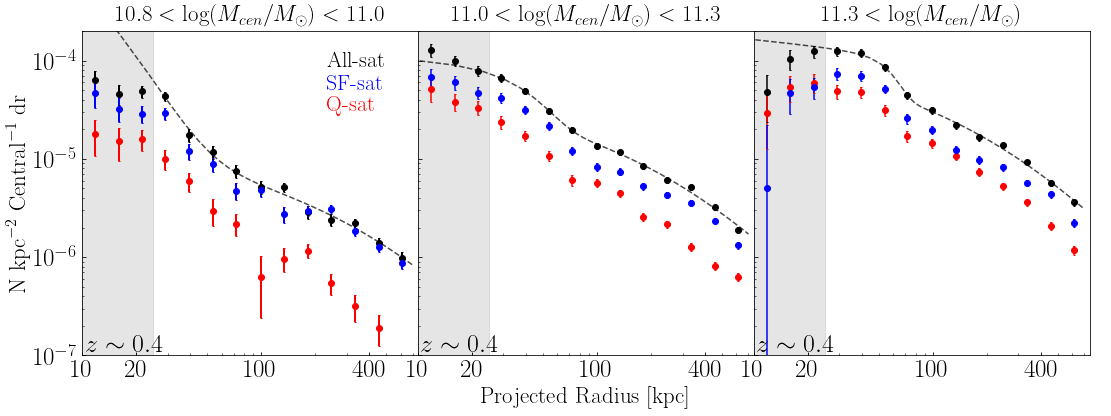

In [62]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=25), plt.rc('ytick', labelsize=25)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
z = 0.4
path = 'CUT_deep_catalogs/test_host_mass/'
print('low mass',len(cat_lm),round(len(cat_lm[cat_lm['sfProb']<0.5])/len(cat_lm),3))
print('median mass',len(cat_mm),round(len(cat_mm[cat_mm['sfProb']<0.5])/len(cat_mm),3))
print('high mass',len(cat_hm),round(len(cat_hm[cat_hm['sfProb']<0.5])/len(cat_hm),3))

bin_centers = np.load(path+'bin_centers.npy')
radial_host_lm = combine_deep_new(10.8,z,'all','all',path=path)
radial_host_mm = combine_deep_new(11.0,z,'all','all',path=path)
radial_host_hm = combine_deep_new(11.3,z,'all','all',path=path)

radial_host_lm_sf = combine_deep_new(10.8,z,'all','ssf',path=path)
radial_host_mm_sf = combine_deep_new(11.0,z,'all','ssf',path=path)
radial_host_hm_sf = combine_deep_new(11.3,z,'all','ssf',path=path)

radial_host_lm_q = combine_deep_new(10.8,z,'all','sq',path=path)
radial_host_mm_q = combine_deep_new(11.0,z,'all','sq',path=path)
radial_host_hm_q = combine_deep_new(11.3,z,'all','sq',path=path)

radial_sim_lm = np.load('radial_tot_lm.npy')
radial_sim_mm = np.load('radial_tot_mm.npy')
radial_sim_hm = np.load('radial_tot_hm.npy')


# calculate red fraction
red_frac_lm = radial_host_lm_q[0]/radial_host_lm[0]
red_frac_mm = radial_host_mm_q[0]/radial_host_mm[0]
red_frac_hm = radial_host_hm_q[0]/radial_host_hm[0]
print('Q-frac for lm central',round(np.average(red_frac_lm[2:],weights=areas[2:]),3))
print('Q-frac for lm central',round(np.average(red_frac_mm[2:],weights=areas[2:]),3))
print('Q-frac for lm central',round(np.average(red_frac_hm[2:],weights=areas[2:]),3))

# plot the distributions
axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='or',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='ob',capsize=1,linewidth=2)
# axs[0].plot(bin_centers,radial_sim_lm,'--og',linewidth=2)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ok',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='or',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='ob',capsize=1)
# axs[1].plot(bin_centers,radial_sim_mm,'--og',linewidth=2)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='ok',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='or',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='ob',capsize=1)
# axs[2].plot(bin_centers,radial_sim_hm,'--og',linewidth=2)

# fitting
fit_x = np.linspace(2,700,num=100)
start = 4

popt_lm,pcov_lm,chi2 = fit_nfw_sersic(bin_centers,radial_host_lm[0],radial_host_lm[1], start=4)
popt_mm,pcov_mm,chi2 = fit_nfw_sersic(bin_centers,radial_host_mm[0],radial_host_mm[1], start=4)
popt_hm,pcov_hm,chi2 = fit_nfw_sersic(bin_centers,radial_host_hm[0],radial_host_hm[1], start=4)

perr_lm = np.sqrt(np.diag(pcov_lm))
perr_mm = np.sqrt(np.diag(pcov_mm))
perr_hm = np.sqrt(np.diag(pcov_hm))

print('rs',popt_lm[0],perr_lm[0])
print('rs',popt_mm[0],perr_mm[0])
print('rs',popt_hm[0],perr_hm[0])

axs[0].plot(fit_x,nfw_sersic(fit_x, popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4]),'--k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_mm[0],popt_mm[1],popt_mm[2],popt_mm[3],popt_mm[4]),'--k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt_hm[0],popt_hm[1],popt_hm[2],popt_hm[3],popt_hm[4]),'--k',alpha=0.7)

axs[0].set_title(r'$10.8<\log(M_{cen}/M_\odot)<11.0$',fontsize=23)
axs[1].set_title(r'$11.0<\log(M_{cen}/M_\odot)<11.3$',fontsize=23)
axs[2].set_title(r'$11.3<\log(M_{cen}/M_\odot)$',fontsize=23)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([1e-7,2e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=23)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

axs[0].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[1].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[2].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.xlabel('Projected Radius [kpc]', fontsize=23)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0) 
plt.savefig('figures/split_host_mass_sfProb'+str(z)+'.png')
plt.show()

low mass 4087 0.607
median mass 2737 0.733
high mass 575 0.868
rs 316.4997068363959 63.516928518298
rs 281.18058043090423 41.8022608473559
rs 214.93766566079526 34.2106846842261


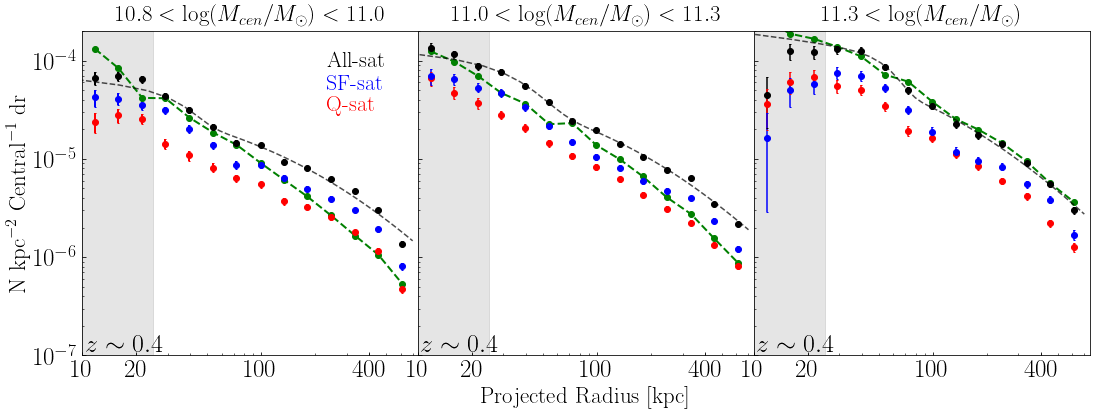

In [33]:
###########
# without isolation criteria

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=25), plt.rc('ytick', labelsize=25)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
z = 0.4

print('low mass',len(cat_lm),round(len(cat_lm[cat_lm['sfProb']<0.5])/len(cat_lm),3))
print('median mass',len(cat_mm),round(len(cat_mm[cat_mm['sfProb']<0.5])/len(cat_mm),3))
print('high mass',len(cat_hm),round(len(cat_hm[cat_hm['sfProb']<0.5])/len(cat_hm),3))

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
path = 'CUT_deep_catalogs/split_host_mass_noiso/'
radial_host_lm = combine_deep_new(10.8,z,'all','all',path=path)
radial_host_mm = combine_deep_new(11.0,z,'all','all',path=path)
radial_host_hm = combine_deep_new(11.3,z,'all','all',path=path)

radial_host_lm_sf = combine_deep_new(10.8,z,'all','ssf',path=path)
radial_host_mm_sf = combine_deep_new(11.0,z,'all','ssf',path=path)
radial_host_hm_sf = combine_deep_new(11.3,z,'all','ssf',path=path)

radial_host_lm_q = combine_deep_new(10.8,z,'all','sq',path=path)
radial_host_mm_q = combine_deep_new(11.0,z,'all','sq',path=path)
radial_host_hm_q = combine_deep_new(11.3,z,'all','sq',path=path)

radial_sim_lm = np.load('radial_tot_lm.npy')
radial_sim_mm = np.load('radial_tot_mm.npy')
radial_sim_hm = np.load('radial_tot_hm.npy')

axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='or',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='ob',capsize=1,linewidth=2)
axs[0].plot(bin_centers,radial_sim_lm,'--og',linewidth=2)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ok',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='or',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='ob',capsize=1)
axs[1].plot(bin_centers,radial_sim_mm,'--og',linewidth=2)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='ok',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='or',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='ob',capsize=1)
axs[2].plot(bin_centers,radial_sim_hm,'--og',linewidth=2)

# fitting
fit_x = np.linspace(2,700,num=100)
start = 4

popt_lm,pcov_lm,chi2 = fit_nfw_sersic(bin_centers,radial_host_lm[0],radial_host_lm[1], start=4)
popt_mm,pcov_mm,chi2 = fit_nfw_sersic(bin_centers,radial_host_mm[0],radial_host_mm[1], start=4)
popt_hm,pcov_hm,chi2 = fit_nfw_sersic(bin_centers,radial_host_hm[0],radial_host_hm[1], start=4)

perr_lm = np.sqrt(np.diag(pcov_lm))
perr_mm = np.sqrt(np.diag(pcov_mm))
perr_hm = np.sqrt(np.diag(pcov_hm))

print('rs',popt_lm[0],perr_lm[0])
print('rs',popt_mm[0],perr_mm[0])
print('rs',popt_hm[0],perr_hm[0])

axs[0].plot(fit_x,nfw_sersic(fit_x, popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4]),'--k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt_mm[0],popt_mm[1],popt_mm[2],popt_mm[3],popt_mm[4]),'--k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt_hm[0],popt_hm[1],popt_hm[2],popt_hm[3],popt_hm[4]),'--k',alpha=0.7)

axs[0].set_title(r'$10.8<\log(M_{cen}/M_\odot)<11.0$',fontsize=23)
axs[1].set_title(r'$11.0<\log(M_{cen}/M_\odot)<11.3$',fontsize=23)
axs[2].set_title(r'$11.3<\log(M_{cen}/M_\odot)$',fontsize=23)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([1e-7,2e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=23)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

axs[0].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[1].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)
axs[2].annotate(r'$z\sim'+str(z)+'$',xy=(0.01,0.01),xycoords='axes fraction',fontsize=26)

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.xlabel('Projected Radius [kpc]', fontsize=23)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/split_host_mass_sfProb'+str(z)+'_noiso.png')
plt.show()

###########
# without isolation criteria

(array([ 5.781e-05,  4.608e-05,  4.319e-05,  3.187e-05,  1.688e-05,
        1.032e-05,  6.574e-06,  5.012e-06,  1.562e-06,  4.342e-07,
       -5.397e-07, -1.325e-06, -1.697e-06, -2.017e-06]), array([9.702e-06, 5.674e-06, 3.969e-06, 2.540e-06, 1.662e-06, 1.096e-06,
       7.413e-07, 5.262e-07, 3.673e-07, 2.589e-07, 1.854e-07, 1.370e-07,
       1.002e-07, 7.125e-08]))


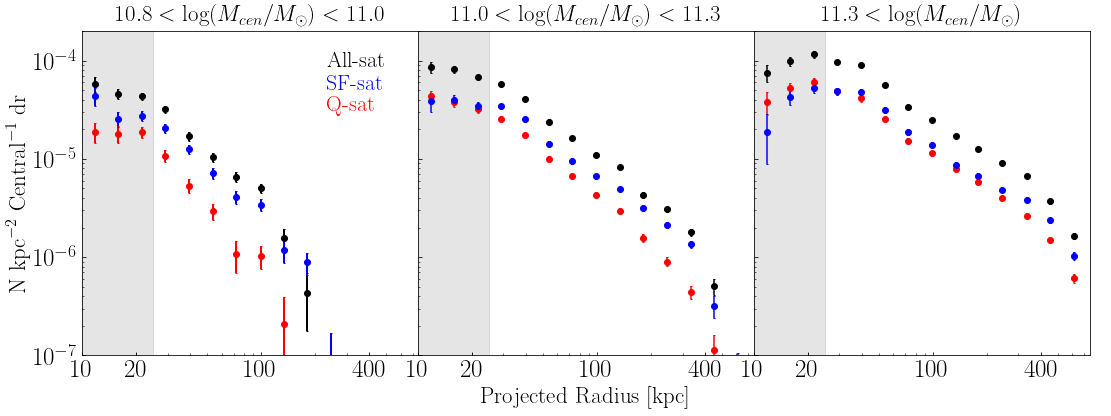

In [34]:
###########
# all_z

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=25), plt.rc('ytick', labelsize=25)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
z = 'allz'

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
path = 'CUT_deep_catalogs/split_host_mass/'

radial_host_lm = combine_deep_new(10.8,z,'all','all',path=path)
radial_host_mm = combine_deep_new(11.0,z,'all','all',path=path)
radial_host_hm = combine_deep_new(11.3,z,'all','all',path=path)

print(radial_host_lm)

radial_host_lm_sf = combine_deep_new(10.8,z,'all','ssf',path=path)
radial_host_mm_sf = combine_deep_new(11.0,z,'all','ssf',path=path)
radial_host_hm_sf = combine_deep_new(11.3,z,'all','ssf',path=path)

radial_host_lm_q = combine_deep_new(10.8,z,'all','sq',path=path)
radial_host_mm_q = combine_deep_new(11.0,z,'all','sq',path=path)
radial_host_hm_q = combine_deep_new(11.3,z,'all','sq',path=path)

axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='or',capsize=1,linewidth=2)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='ob',capsize=1,linewidth=2)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ok',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='or',capsize=1)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='ob',capsize=1)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='ok',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='or',capsize=1)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='ob',capsize=1)

axs[0].set_title(r'$10.8<\log(M_{cen}/M_\odot)<11.0$',fontsize=23)
axs[1].set_title(r'$11.0<\log(M_{cen}/M_\odot)<11.3$',fontsize=23)
axs[2].set_title(r'$11.3<\log(M_{cen}/M_\odot)$',fontsize=23)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([1e-7,2e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=23)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[1].axvspan(10, 25, alpha=0.1, color='k')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

# print all,sf,q info on figure
axs[0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.xlabel('Projected Radius [kpc]', fontsize=23)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/split_host_mass_sfProb'+str(z)+'.png')
plt.show()

###########
# all_z

### split both central mass and central sfq

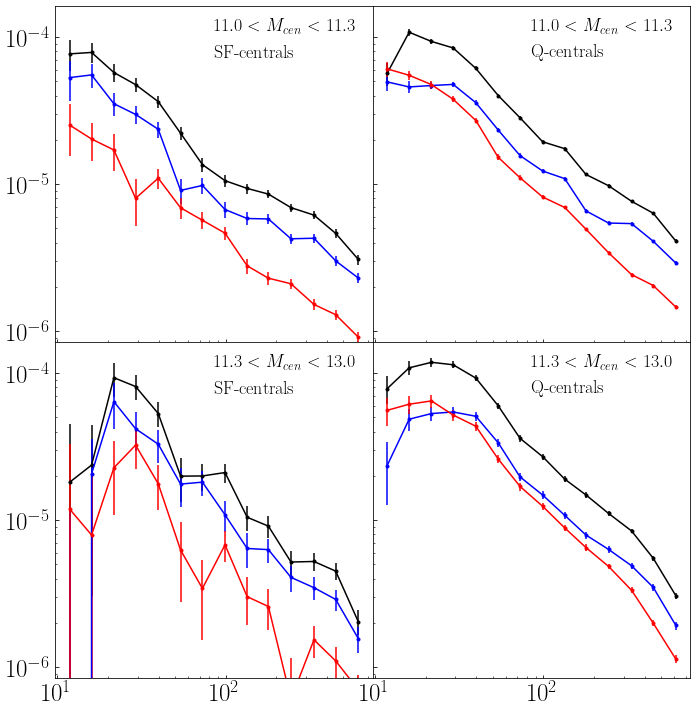

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey=True, figsize=(10, 10),gridspec_kw={'height_ratios':[1,1]})

path = 'CUT_deep_catalogs/split_host_color_mass/'
z=0.6

for i, mass_host_low in enumerate([[11.0,11.3],[11.3,13.0]]):
    for j, csfq in enumerate(['csf','cq']):
        radial_all = combine_deep_new(mass_host_low[0],z,csfq,'all',path=path)
        radial_ssf = combine_deep_new(mass_host_low[0],z,csfq,'ssf',path=path)
        radial_sq = combine_deep_new(mass_host_low[0],z,csfq,'sq',path=path)
    
        axs[i][j].errorbar(bin_centers,radial_all[0],yerr=radial_all[1],fmt='.-k')
        axs[i][j].errorbar(bin_centers,radial_ssf[0],yerr=radial_ssf[1],fmt='.-b')
        axs[i][j].errorbar(bin_centers,radial_sq[0],yerr=radial_sq[1],fmt='.-r')
        
        axs[i][j].annotate(r'$'+str(mass_host_low[0])+'<M_{cen}<'+str(mass_host_low[1])+'$',
                           xy=(0.5,0.92),xycoords='axes fraction',fontsize=18)
        if csfq == 'csf':
            print_csfq = 'SF-centrals'
        else:
            print_csfq = 'Q-centrals'
            
        axs[i][j].annotate(print_csfq,xy=(0.5,0.85),xycoords='axes fraction',color='k',fontsize=18)
        
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show()

### influence of mass/ sfprob/photoz error

In [ ]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.savefig('figures/radial_evolution_evolving_masscut.png')
plt.show()